In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Misc
import warnings
import tensorflow as tf
import keras 
warnings.filterwarnings('ignore')

print(sys.version)
print(os.path)
print("Keras: ",keras.__version__)
print("TF: ",tf.__version__)
print("\n\nYou are good to go")

#
from approximator import *
from q_learning_nn import *
from evaluation import *

#import environment
sys.path.append(r'../virl')
import virl



3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
<module 'posixpath' from '/Users/wayenvan/opt/anaconda3/lib/python3.8/posixpath.py'>
Keras:  2.4.3
TF:  2.3.1


You are good to go


## Training phase
define some properities

In [2]:
#create training environment, I am using P1
env_train = virl.Epidemic(stochastic=False, noisy=False) 

d_states = env_train.observation_space.shape[0]
n_actions = env_train.action_space.n

alpha = 0.001
nn_config = [36,36,36]
BATCH_SIZE = 20
BUFFER_SIZE = 10000

start training

In [22]:

# Init the tow networks
nn_func_approximator = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
nn_func_approximator_target = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)

# Training   
stats = q_learning_nn(env_train,nn_func_approximator, nn_func_approximator_target, 1000, max_steps_per_episode=400, 
                      epsilon_init=0.1, epsilon_decay=0.995, epsilon_min=0.001, fn_model_out=r"./cartpole_temp.h5")

episode: 999/1000, score: 51, epsilon: 0.001

## Evaluation phase

In [4]:
#load test environment
env = virl.Epidemic(problem_id=2) 

#load the approximator from there
approximator_trained = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
load_approximator(approximator_trained, r"./training_data/cartpole_finished.h5")

epsilon_fixed = 0.1
policy_greedy = policy_generator(env,epsilon_fixed, approximator_trained, policy_type="greedy")
policy_random = policy_generator(env, epsilon_fixed, approximator_trained)

states_test1, rewards_test1, actions_test1 = exec_agent(policy_greedy, env)
states_test2, rewards_test2, actions_test2 = exec_agent(policy_random, env)

Plot all figures

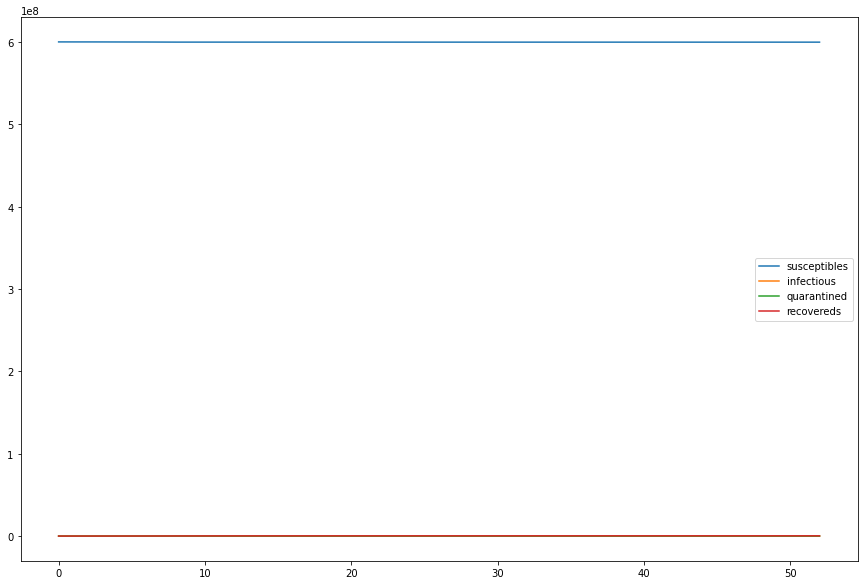

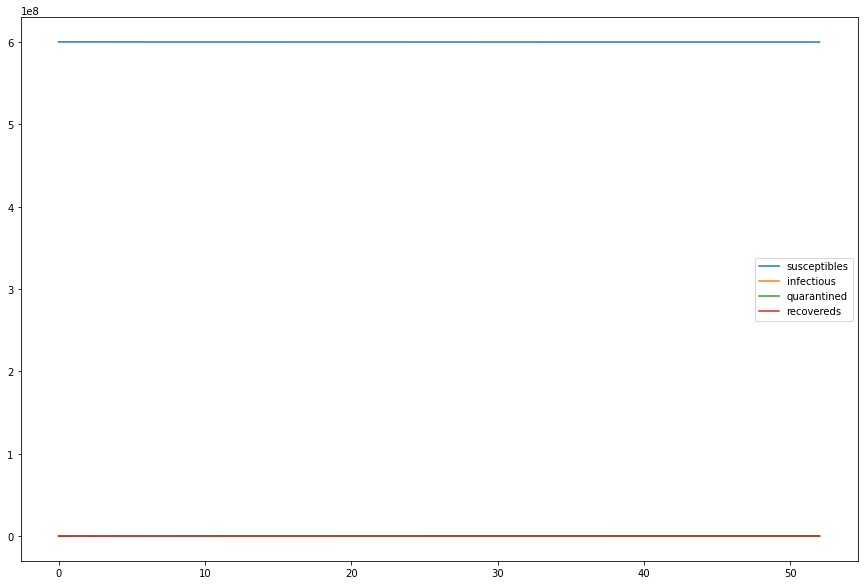

In [8]:
d_state_names=("susceptibles", "infectious", "quarantined", "recovereds")

plt.figure(figsize=(15,10))
for i in range(4):
    plt.plot(list(zip(*states_test2))[i], label=d_state_names[i])
plt.legend()

plt.figure(figsize=(15,10))
for i in range(4):
    plt.plot(list(zip(*states_test1))[i], label=d_state_names[i])
plt.legend()